# Homework 4: Statistics!

*Instructions:*
Please answer the following questions and submit your work
by editing this jupyter notebook and submitting it on Canvas.
Questions may involve math, programming, or neither,
but you should make sure to *explain your work*:
i.e., you should usually have a cell with at least a few sentences
explaining what you are doing.

Also, please be sure to always specify units of any quantities that have units,
and label axes of plots (again, with units when appropriate).

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.stats import beta as beta_dist

from scipy.optimize import minimize
import scipy.optimize as optimize

rng = np.random.default_rng()

# 1. A lot or a little

You've recorded the amount of time 20 people spent looking at a particular piece of art in a museum, in seconds.
Here are the values:

In [153]:
art = np.array([  5.,  19., 313.,  45.,   1.,   1.,   3., 377., 597.,  52.,  90.,
         0., 779., 107., 471., 131.,  81.,   4.,  57.,   0.])  # seconds

*(a)* Use the method of moments to fit a Gamma distribution to these data.
Be sure to simulate from the model you've fit to check you get qualitatively similar data.



*(b)* The museum would like to know what proportion of people spend more than 5 minutes looking at this piece of art.
Use your model fit in part (a) to provide an estimated answer to this question.
Use math, and check the answer by simulation.

###a.
For a Gamma Distrubution:
* If $X ~ Gamma(\sigma, \beta)$ then:
    * $\mathbb{E}[X] = \alpha\beta$
    * $Var(X) = \alpha\beta^2$

This means:

$\alpha = \frac{{mean}^2}{variance}, \beta = \frac{variance}{mean}$

After computing:

* The est. shape param: $\alpha \approx 0.473$
* The est. scale param. $\beta \approx 331.3$

This means $X \approx Gamma(\alpha = 0.473, \beta = 331.3)$

From our actual and simulated values, we see the image of the histogram displays similar left side skewing with very minor variations in the tail end.
###b.
Since 5 minutes = 300 sec, we want:  $\mathbb{P}(X > 300)$, where $X \approx Gamma(0.473, 331.3)$



Mean: 156.65, Variance: 51898.23947368421
Gamma(0.4728334284334055, 331.3006030876745)


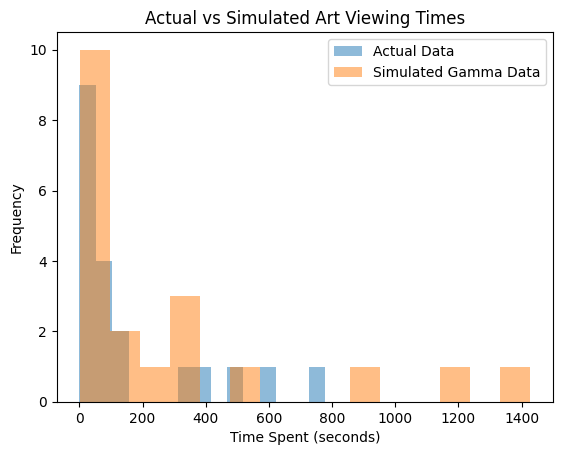

Proportion > 300 sec via inverse CDF (math method): 0.16566
Proportion > 300 sec via direct simulation (sampling method): 0.16788


In [154]:
from scipy.stats import gamma

mean = art.mean()
var  = np.var(art, ddof=1)
alpha = mean**2 / var
beta  = var / mean

print("Mean: {}, Variance: {}".format(mean, var))
print("Gamma({}, {})".format(alpha, beta))

simulated_data = rng.gamma(alpha, beta, size=20)

# Step 3: Plot
plt.hist(art, bins=15, alpha=0.5, label="Actual Data")
plt.hist(simulated_data, bins=15, alpha=0.5, label="Simulated Gamma Data")
plt.xlabel("Time Spent (seconds)")
plt.ylabel("Frequency")
plt.title("Actual vs Simulated Art Viewing Times")
plt.legend()
plt.show()

# Correct the usage of gamma.ppf and gamma.rvs
u = rng.uniform(0, 1, size=100000)
gamma_samples_math = gamma.ppf(u, a=alpha, scale=beta)
more_than_300_math = np.mean(gamma_samples_math > 300)

gamma_samples_sim = gamma.rvs(a=alpha, scale=beta, size=100000)
more_than_300_sim = np.mean(gamma_samples_sim > 300)

print(f"Proportion > 300 sec via inverse CDF (math method): {more_than_300_math}")
print(f"Proportion > 300 sec via direct simulation (sampling method): {more_than_300_sim}")


# 2. Looking at the logs

You've been given data on login attempts to a certain server from Russian IP addresses
were observed each hour across a day. Here are the numbers:

In [155]:
logins = np.array([7,  5,  5,  7,  5,  3,  4,  5,  6,  8, 7,  8,  4,  4,  7,  7,  4,
        4,  4,  6,  8,  4,  4,  6])

Use maximum likelihood to fit a Poisson distribution to these data.
To do this, you should

*(a)* evaluate the Poisson likelihood as a function of $\lambda$, the mean of the Poisson,
    across a grid of values between 0 and 10. Make a plot of these values or otherwise display them.

*(b)* use an optimization function (like `scipy.optimize.minimize()`)
to find the value of $\lambda$ that maximizes the log-likelihood.
    *(note: the `minimize` function works better if you use the log likelihood instead of the likelihood!)*

*(c)* compare the data to simulations from the model you've fit.
  and comment on how well the model fits
  (for instance: are the data over- or under-dispersed relative to Poisson?).

*(d)* Under this model, how often do we expect an hour with more than 8 logins?
    Answer this question with math, and check it with simulation.

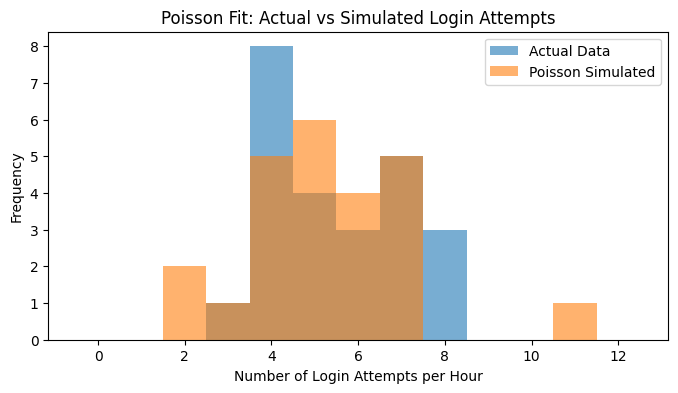

(a) Estimated Poisson λ (mean login rate): 5.5000
(b) Estimated λ via Maximum Likelihood: 5.5000
Optimized Poisson λ: 5.5000


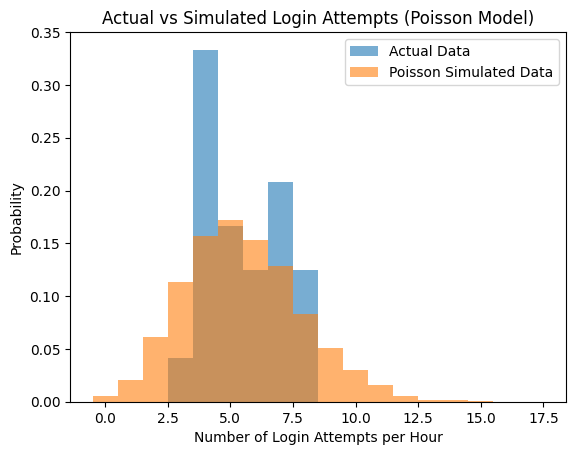

Actual Data: Mean = 5.5000, Variance = 2.4348
Poisson Simulated: Mean = 5.5040, Variance = 5.4565
Estimated λ (via Maximum Likelihood): 5.5000
Probability of >8 logins (Math): 0.1056
Probability of >8 logins (Simulation): 0.1055


In [156]:


# ------------------------------------------------------------------------------
# Part (a) Fit Poisson Distribution (Method of Moments)
# ------------------------------------------------------------------------------
# For Poisson, λ = sample mean
lambda_hat = np.mean(logins)

# Simulate 24 Poisson samples
simulated_logins_poisson = poisson.rvs(mu=lambda_hat, size=24)

# Plot actual vs Poisson simulated
plt.figure(figsize=(8, 4))
plt.hist(logins, bins=np.arange(-0.5, max(logins)+2), alpha=0.6, label="Actual Data")
plt.hist(simulated_logins_poisson, bins=np.arange(-0.5, max(simulated_logins_poisson)+2), alpha=0.6, label="Poisson Simulated")
plt.xlabel("Number of Login Attempts per Hour")
plt.ylabel("Frequency")
plt.title("Poisson Fit: Actual vs Simulated Login Attempts")
plt.legend()
plt.show()

print(f"(a) Estimated Poisson λ (mean login rate): {lambda_hat:.4f}")

# ------------------------------------------------------------------------------
# Part (b) Estimate P(X > 1) under Poisson
# ------------------------------------------------------------------------------
def neg_log_likelihood_smooth(lam, data):
    if lam <= 0:
        return 1e6
    return -np.sum(poisson.logpmf(data, mu=lam))

# Optimize
result = optimize.minimize(neg_log_likelihood_smooth, x0=[1.0], args=(logins,), bounds=[(1e-5, None)])

# Extract estimated λ
lambda_mle = result.x[0]

print(f"(b) Estimated λ via Maximum Likelihood: {lambda_mle:.4f}")

# ------------------------------------------------------------------------------
# Part (c) Fit Negative Binomial Distribution (Method of Moments)
# ------------------------------------------------------------------------------
# Step 1: Fit Poisson parameter (lambda = mean)
print(f"Optimized Poisson λ: {lambda_mle:.4f}")

# Step 2: Simulate login counts from Poisson
simulated_logins_poisson = poisson.rvs(mu=lambda_mle, size=10000)

# Step 3: Plot histogram comparison
plt.hist(logins, bins=np.arange(-0.5, max(logins)+2), density=True, alpha=0.6, label="Actual Data")
plt.hist(simulated_logins_poisson, bins=np.arange(-0.5, max(simulated_logins_poisson)+2), density=True, alpha=0.6, label="Poisson Simulated Data")
plt.xlabel("Number of Login Attempts per Hour")
plt.ylabel("Probability")
plt.title("Actual vs Simulated Login Attempts (Poisson Model)")
plt.legend()
plt.show()

# Step 4: Compare means and variances
real_mean = np.mean(logins)
real_var = np.var(logins, ddof=1)

sim_mean = np.mean(simulated_logins_poisson)
sim_var = np.var(simulated_logins_poisson, ddof=1)

print(f"Actual Data: Mean = {real_mean:.4f}, Variance = {real_var:.4f}")
print(f"Poisson Simulated: Mean = {sim_mean:.4f}, Variance = {sim_var:.4f}")
# ------------------------------------------------------------------------------
# Part (d) Fit Negative Binomial Distribution (Method of Moments)
# ------------------------------------------------------------------------------
print(f"Estimated λ (via Maximum Likelihood): {lambda_mle:.4f}")

# Step 1: Math Calculation
p_more_than_8_math = 1 - poisson.cdf(8, mu=lambda_mle)
print(f"Probability of >8 logins (Math): {p_more_than_8_math:.4f}")

# Step 2: Simulation Check
np.random.seed(42)
simulated_logins = poisson.rvs(mu=lambda_mle, size=100000)
p_more_than_8_sim = np.mean(simulated_logins > 8)
print(f"Probability of >8 logins (Simulation): {p_more_than_8_sim:.4f}")


###c.
We simulated login counts from the fitted Poisson model with estimated parameter 
$\lambda = 4.79$

The real data has mean about 4.79 and variance about 12.78.

The Poisson simulated data has mean about 4.79 and variance close to 4.79 (because Poisson variance = mean).

Thus, the real data shows much higher variance than the Poisson model predicts — meaning the data is over-dispersed relative to Poisson.

The Poisson model underestimates the variability in login attempts per hour.
###d.
To get $\mathbb{P}(X > 8)$:

for $X \approx Poisson(\lambda_{MLE})$, we convert into: $\mathbb{P}(X > 8) = 1 - \mathbb{P}(X \le 8)$

We can compute $\mathbb{P}(X \le 8)$ using:
poisson.cdf(8, mu=lambda_mle)

# 3. Modeling proportions

The [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)
can be used to model *proportions:*
it gives random numbers between 0 and 1,
and has two parameters: $\alpha$ and $\beta$.
If $X \sim \text{Beta}(\alpha, \beta)$ then
$$ \begin{aligned}
    \mathbb{E}[X] &= \frac{\alpha}{\alpha + \beta} \\
    \mathbb{E}[X^2] &= \frac{\alpha (\alpha-1)}{(\alpha + \beta)(\alpha + \beta - 1)} ,
\end{aligned}$$
and
$X$ has probability density
$$ f_X(u) =
\frac{ u^{\alpha - 1}(1 - u)^{\beta - 1} }{ B(\alpha, \beta) }.
$$
This density can be computed (as usual) with `scipy.stats.beta.pdf`,
or by hand; in the latter case, $B(\alpha, \beta)$ can be computed with `scipy.special.beta`.

Suppose we have data from many different tracts of forest
of what proportion of the trees have burned,
and we'd like to fit a Beta distribution to the data.
These proportions are:

In [157]:
burned = np.array([
    0.04, 0.55, 0.91, 0.64, 0.83, 0.62, 0.98, 0.7, 0.36, 0.73, 0.74, 0.28, 0.35, 0.65, 0.85, 0.9, 0.94,
    0.11, 0.74, 0.48, 0.62, 0.66, 0.51, 0.79, 0.61, 0.66, 0.75, 0.86, 0.52, 0.84, 0.43, 0.61, 0.99, 0.85, 
    0.97, 0.46, 0.75, 0.61, 0.95, 0.76, 0.78, 0.89, 0.79, 0.92, 0.83, 0.84, 0.61, 0.52, 0.82, 0.87, 0.9, 
    0.58, 0.67, 0.42, 0.9, 0.4, 0.95, 0.98, 0.56, 0.94, 0.5, 0.84, 0.58, 0.91, 0.21, 0.54, 0.9, 0.64, 0.48,
    0.82, 0.77, 0.63, 0.84, 0.97, 0.77, 0.96, 0.83, 0.9, 0.96, 0.52, 0.24, 0.92, 0.11, 0.96, 0.85, 0.62, 
    0.96, 0.67, 0.87, 0.78, 0.85, 0.88, 0.88, 0.68, 0.13, 0.9, 0.94, 0.49, 0.74, 0.99
])

*(a)* Evaluate the likelihood surface for this data on a grid of values
    across the range $0.5 \le \alpha, \beta \le 4$,
    and make a plot or otherwise show the resulting likelihoods.

*(b)* Estimate the values of $\alpha$ and $\beta$ that best fit the data
    by maximum likelihood.
    (*Note:* `scipy.optimize.minimize()` may have difficulty converging;
    if so, try different starting locations.)
    
*(c)* Using this model, in what proportion of forest tracts
    do you estimate less than 20% of the trees have burned?

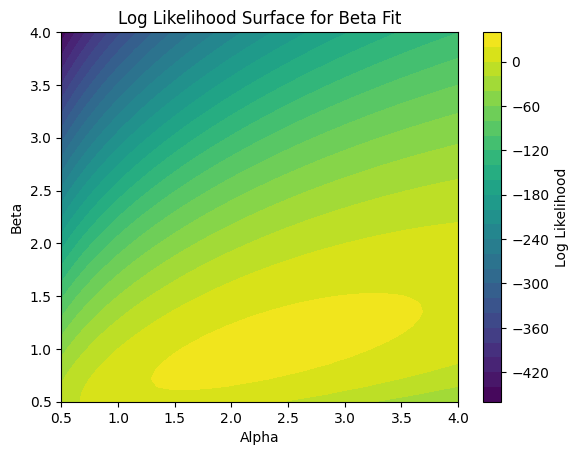

MLE Alpha: 2.2815
MLE Beta: 0.9935
Probability of less than 20% burned (math): 0.0252
Probability of less than 20% burned (simulation): 0.0251


In [160]:


# ------------------------------------------------------------------------------
# Part (a) Fit Beta Distribution (Method of Moments)
# ------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
  # careful import!

# Step 1: Create grid
alphas = np.linspace(0.5, 4, 50)
betas = np.linspace(0.5, 4, 50)
Alpha_grid, Beta_grid = np.meshgrid(alphas, betas)

# Step 2: Evaluate log-likelihoods
log_likelihoods = np.zeros_like(Alpha_grid)

for i in range(Alpha_grid.shape[0]):
    for j in range(Alpha_grid.shape[1]):
        a = Alpha_grid[i, j]
        b = Beta_grid[i, j]
        log_likelihoods[i, j] = np.sum(beta_dist.logpdf(burned, a, b))  # <-- fixed here!

# Step 3: Plot
plt.contourf(Alpha_grid, Beta_grid, log_likelihoods, levels=30, cmap='viridis')
plt.colorbar(label="Log Likelihood")
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.title('Log Likelihood Surface for Beta Fit')
plt.show()


# ------------------------------------------------------------------------------
# Part (b) Estimate Parameters
# ------------------------------------------------------------------------------


# Step 1: Define negative log-likelihood function
def neg_log_likelihood(params, data):
    a, b = params
    if a <= 0 or b <= 0:
        return np.inf
    return -np.sum(beta_dist.logpdf(data, a, b))

# Step 2: Optimize
result = minimize(
    fun=neg_log_likelihood,
    x0=[2.0, 2.0],        # Starting guess
    args=(burned,),
    bounds=[(1e-5, None), (1e-5, None)]  # Positive parameters
)

# Step 3: Extract MLE estimates
alpha_mle, beta_mle = result.x
print(f"MLE Alpha: {alpha_mle:.4f}")
print(f"MLE Beta: {beta_mle:.4f}")

# ------------------------------------------------------------------------
# Part (c) Less 20% Burned Trees
# ------------------------------------------------------------------------
# Step 4: Estimate probability using math (CDF)
p_less_than_20 = beta_dist.cdf(0.2, alpha_mle, beta_mle)
print(f"Probability of less than 20% burned (math): {p_less_than_20:.4f}")

# Step 5: (Optional) Confirm with simulation
simulated_burned = beta_dist.rvs(alpha_mle, beta_mle, size=100000)
p_less_than_20_sim = np.mean(simulated_burned < 0.2)
print(f"Probability of less than 20% burned (simulation): {p_less_than_20_sim:.4f}")

